In [9]:
from wmpy.trader.utility import load_bar, load_tick
from wmpy.trader.utility import product_info_df, trade_days_list
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

Backtest date range: 20210104 - 20210226
20210326 00:25:56.385060 - INFO: 20210104 start!
20210326 00:25:56.385223 - INFO: lr_strategy subscribe: IF2103
results are saved at: results/
20210326 00:26:06.363340 - INFO: 20210105 start!
20210326 00:26:06.363544 - INFO: lr_strategy subscribe: IF2103
results are saved at: results/
20210326 00:26:16.116255 - INFO: 20210106 start!
20210326 00:26:16.116435 - INFO: lr_strategy subscribe: IF2103
下单 svUEL26 2021-01-06 09:43:00
results are saved at: results/
20210326 00:26:24.787660 - INFO: 20210107 start!
20210326 00:26:24.788021 - INFO: lr_strategy subscribe: IF2103
results are saved at: results/
20210326 00:26:35.832129 - INFO: 20210108 start!
20210326 00:26:35.833072 - INFO: lr_strategy subscribe: IF2103
下单 mPYSu9 2021-01-08 09:34:00.300000
下单 mPYSu50 2021-01-08 09:55:00.300000
下单 mPYSu121 2021-01-08 10:31:00.300000
results are saved at: results/
20210326 00:26:47.833611 - INFO: 20210111 start!
20210326 00:26:47.834391 - INFO: lr_strategy subsc

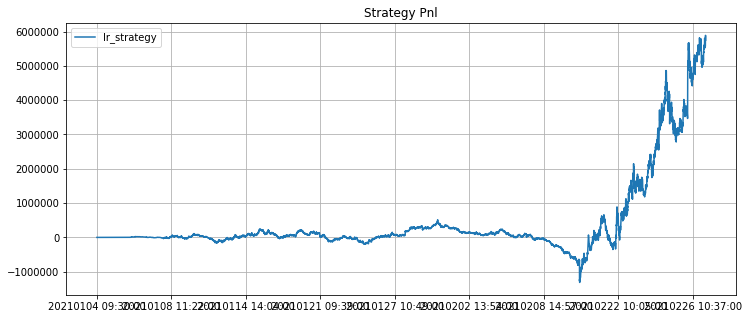

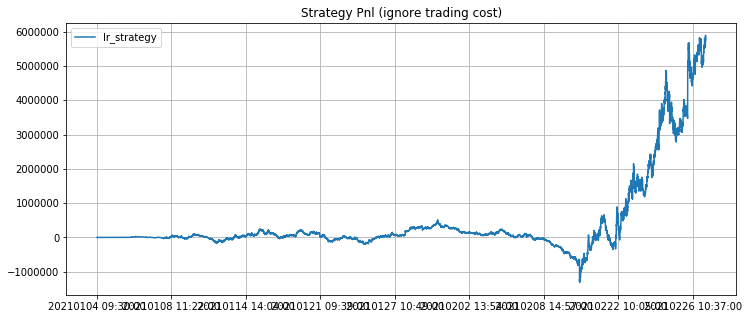

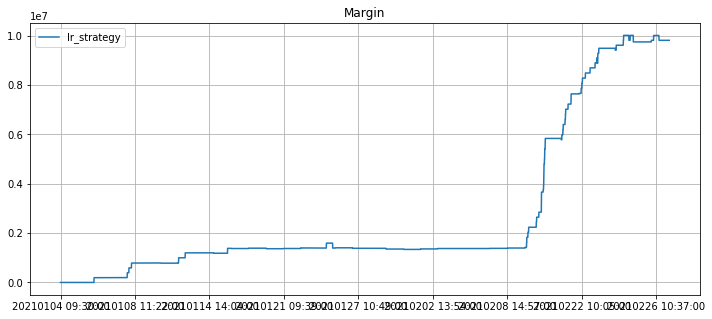

In [10]:
from FuturePlatform import *


@simulation(start_date="2020-10-01", end_date="2021-02-28",
            delay_msecs=1000, close_today=True, save_fold = "results", verbose = 1,
            parameters={"lr_strategy": {"OPEN_THRESHOLD": 0.1,"CLOSE_THRESHOLD":-1}
                        })
class CTASample(CTABase):
    def __init__(self):
        super().__init__()

    def init_strategy(self, OPEN_THRESHOLD, CLOSE_THRESHOLD):
        """
        所有初始化工作写在该函数内，线性回归策略
        """
        self.WINDOW = 6      # 考察窗口长度
        self.OPEN_THRESHOLD = OPEN_THRESHOLD        # 开仓阈值
        self.CLOSE_THRESHOLD = CLOSE_THRESHOLD        # 关仓阈值
        self.w = [-0.00749219,0.01767106,-0.01522419, -0.00949246, 0.04231612, 0.97126633] #线性回归参数
        self.b = 4.70118259 #线性回归参数
        self.factor = []                # 存储因子计算数值
        self.price_list = []              # 存储价格信息，用于计算均线
        self.main_symbol = "IF2103"            # 策略订阅和计算的合约品种是 IF2103
        self.subscribe([self.main_symbol])     # 订阅合约代码      
        self.max_trade = 20
        self.max_order = 10
        
#         print(self.get_trading_day())
#         print(self.get_dominant_future('IF', 1))
#         print(self.get_expireday("IF2103"))
#         print(self.get_option_list("cu2105"))


    def on_tick(self, tick):
        
        if tick.datetime.second != 0:
            return
        if self.max_trade < 0 or self.max_order < 0:
            return
        self.price_list.append((tick.bid_price_1 + tick.ask_price_1)/2)
        self.orderid = self.gen_orderid()
        if len(self.price_list) >= self.WINDOW:
            self.factor.append(np.dot(self.price_list[-self.WINDOW:],self.w)+self.b-self.price_list[-1])
            if len(self.factor) > 1 and self.factor[-1] > self.OPEN_THRESHOLD and self.factor[-2] < self.OPEN_THRESHOLD:
                order = OrderData(symbol = "IF2103", direction = Direction.LONG, 
                                  price = tick.last_price, volume = 1,
                                  type = OrderType.LIMIT, orderid = self.orderid,
                                  datetime = tick.datetime)
                print("下单", order.orderid, order.datetime)
                self.max_order -= 1
                self.send_order(order)
            elif len(self.factor) > 1 and self.factor[-1] < self.CLOSE_THRESHOLD and self.factor[-2] > self.CLOSE_THRESHOLD:
                order = OrderData(symbol = "IF2103", direction = Direction.SHORT, 
                                  price = tick.last_price, volume = 1, 
                                  type = OrderType.LIMIT, orderid = self.orderid,
                                  datetime = tick.datetime)
                print("下单", order.orderid, order.datetime)
                self.max_order -= 1
                self.send_order(order)

    def on_order(self, order):
#         if order.status != Status.CANCELLED:
#             print(">>>>>> 撤单：", order.orderid, order.status)
#             self.cancel_order(order)
        pass

    def on_trade(self, trade):
        self.max_trade -= 1


In [11]:
import os
import pandas as pd

fold = 'results'
strategy = 'lr_strategy'
day = '20210108'
pd.read_csv(os.path.join(fold, 'order_detail', '%s_%s.csv'%(strategy, day)), index_col = 0)

,委托合约,买卖,开平,手数,未成交,报单价,挂单状态,成交均价,报单时间,详细状态,报单引用,撤单时间,成交时间,手续费
0,IF2103,卖,开仓,1,0,5533.0,全部成交,5534.0,09:34:01,全部成交报单已提交,mPYSu9,-,09:34:01,40.84
1,IF2103,卖,开仓,1,0,5495.4,全部成交,5495.4,09:55:01,全部成交报单已提交,mPYSu50,-,09:56:50,40.57
2,IF2103,卖,开仓,1,0,5513.0,全部成交,5513.6,10:31:01,全部成交报单已提交,mPYSu121,-,10:31:01,40.70


In [12]:
pd.read_csv(os.path.join(fold, 'position_detail', '%s_%s.csv'%(strategy, day)), index_col = 0)

,持仓合约,买卖,总仓,开仓均价,浮动盈亏,持仓占用,持仓市值
0,IF2103,卖,4,5493.25,-3780.0,786124.8,6595680.0
